# Feature Engineering with Fast cuDF-Pandas!
One of the most powerful feature engineering techniques is `groupby(COL1)[COL2].agg(STAT)`. This is where we group by `COL1` column and aggregate (i.e. compute) a statistic `STAT` over another column `COL2`. This is the underlying method to compute `target encoding` and `count encoding`. By computing raw statistics and inputting them into our model, our model can do more than only receiving `TE` or `CE`. This notebook illustrates creating 50 engineered features, but we can create hundreds more and improve CV score and LB score!

When our dataset has millions of rows like Kaggle's Backpack competition, then `groupby` operations take time to compute. The fastest way to compute a `groupby` aggregation is to use GPU with [RAPIDS cuDF-Pandas][1] library.

There are two ways to use [RAPIDS cuDF][2]. We can write cuDF code which looks just like Pandas code and starts with `import cudf`. Or we can write normal Pandas code with `import pandas` but before that we add the cell magic command `%load_ext cudf.pandas`. By adding this magic command all calls to Pandas afterward will use [RAPIDS cuDF][2] behind the scenes taking advantage of the massive speed boost of GPU!

Alternatively, we can use [cuDF-Polars][3]. To use [cuDF-Polars][3], we write Polars code with lazy frame. Then the final call includes `.collect(engine="gpu")` which will run all previous Polars code behind the scenes with [RAPIDS cuDF][2].

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://rapids.ai/polars-gpu-engine/

# RAPIDS v25.02
[RAPIDS v25.02][1] was just released Feb 15, 2025! Instructions on installing RAPIDS is [here][1]. On Kaggle, the easiest way to pip install new libraries is to do it once in a `Utility Script` notebook. Then whenever we attach the `Utility Script` notebook to another Kaggle notebook, the second Kaggle notebook immediately gets the benefit of the pip installed libraries. We created a [RAPIDS 25.02][1] `Utility Script` [here][2], and we attach it to the notebook you are reading. Therefore the notebook you are reading can import RAPIDS v25.02 without needing to pip install!

[1]: https://docs.rapids.ai/install/
[2]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

# GPU Acceleration
We activate [cuDF-Pandas][1] with the magic command `%load_ext cudf.pandas` below. Afterward, all calls to Pandas will use fast GPU [RAPIDS cuDF][2] behind the scenes! Since we attached `Utility Script` notebook [here][3] to the notebook you are reading, we will be using the new [RAPIDS v25.02][2]!

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

In [1]:
%load_ext cudf.pandas

import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Load Data
We load train, train extra, and test data. The combined train data has 4 million rows! This means we do not need to fear overfitting train. We can make hundreds/thousands of new features and every time our CV improves our LB will improve too!

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
train_extra = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
train = pd.concat([train, train_extra], axis=0, ignore_index=True)

In [3]:
original_df = pd.read_csv("/kaggle/input/student-bag-price-prediction-dataset/Noisy_Student_Bag_Price_Prediction_Dataset.csv")
original_df = original_df.groupby("Weight Capacity (kg)").Price.mean()
original_df.name = "original_Price"
train = train.merge(original_df, on="Weight Capacity (kg)", how="left")
test = test.merge(original_df, on="Weight Capacity (kg)", how="left")

In [4]:
# merge features from original to train and test df's
original_df = pd.read_csv("/kaggle/input/student-bag-price-prediction-dataset/Noisy_Student_Bag_Price_Prediction_Dataset.csv")
original_df = original_df.loc[(original_df["Weight Capacity (kg)"]>5)&(original_df["Weight Capacity (kg)"]<30)]
original_df.columns = [f"original_{c}" for c in original_df.columns]
train = train.merge(original_df.iloc[:,:-1], left_on="Weight Capacity (kg)", right_on="original_Weight Capacity (kg)", how="left")
#train_df = train_df.drop("id",axis=1)
test = test.merge(original_df.iloc[:,:-1], left_on="Weight Capacity (kg)", right_on="original_Weight Capacity (kg)", how="left")
display(train.info(), test.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 21 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   Brand                          object
 2   Material                       object
 3   Size                           object
 4   Compartments                   float64
 5   Laptop Compartment             object
 6   Waterproof                     object
 7   Style                          object
 8   Color                          object
 9   Weight Capacity (kg)           float64
 10  Price                          float64
 11  original_Price                 float64
 12  original_Brand                 object
 13  original_Material              object
 14  original_Size                  object
 15  original_Compartments          float64
 16  original_Laptop Compartment    object
 17  original_Waterproof            object
 18  original_Style    

None

None

# Feature Engineer Columns
We will engineer 8 new columns by combining existing columns.

In [5]:
CATS = list(train.drop(columns=["Price", "id", "Weight Capacity (kg)", "original_Weight Capacity (kg)"]).columns)
print(f"There are {len(CATS)} categorical columns:")
print( CATS )
print(f"There are 2 numerical columns:")
print( ["Weight Capacity (kg)", "original_Weight Capacity (kg)"] )

There are 17 categorical columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'original_Price', 'original_Brand', 'original_Material', 'original_Size', 'original_Compartments', 'original_Laptop Compartment', 'original_Waterproof', 'original_Style', 'original_Color']
There are 2 numerical columns:
['Weight Capacity (kg)', 'original_Weight Capacity (kg)']


In [6]:
COMBO = []
for i,c in enumerate(CATS):
    #print(f"{c}, ",end="")
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)]
    test[c] = combine[len(train):]
    n = f"{c}_wc"
    train[n] = train[c]*100 + train["original_Weight Capacity (kg)"]
    test[n] = test[c]*100 + test["original_Weight Capacity (kg)"]
    COMBO.append(n)
for i,c in enumerate(CATS):
    #print(f"{c}, ",end="")
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)]
    test[c] = combine[len(train):]
    n = f"{c}_orig_wc"
    train[n] = train[c]*100 + train["original_Weight Capacity (kg)"]
    test[n] = test[c]*100 + test["original_Weight Capacity (kg)"]
    COMBO.append(n)
print()
print(f"We engineer {len(COMBO)} new columns!")
print( COMBO )


We engineer 34 new columns!
['Brand_wc', 'Material_wc', 'Size_wc', 'Compartments_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc', 'original_Price_wc', 'original_Brand_wc', 'original_Material_wc', 'original_Size_wc', 'original_Compartments_wc', 'original_Laptop Compartment_wc', 'original_Waterproof_wc', 'original_Style_wc', 'original_Color_wc', 'Brand_orig_wc', 'Material_orig_wc', 'Size_orig_wc', 'Compartments_orig_wc', 'Laptop Compartment_orig_wc', 'Waterproof_orig_wc', 'Style_orig_wc', 'Color_orig_wc', 'original_Price_orig_wc', 'original_Brand_orig_wc', 'original_Material_orig_wc', 'original_Size_orig_wc', 'original_Compartments_orig_wc', 'original_Laptop Compartment_orig_wc', 'original_Waterproof_orig_wc', 'original_Style_orig_wc', 'original_Color_orig_wc']


In [7]:
FEATURES = CATS + ["Weight Capacity (kg)", "original_Weight Capacity (kg)"] + COMBO
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )
train.info()

We now have 53 columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'original_Price', 'original_Brand', 'original_Material', 'original_Size', 'original_Compartments', 'original_Laptop Compartment', 'original_Waterproof', 'original_Style', 'original_Color', 'Weight Capacity (kg)', 'original_Weight Capacity (kg)', 'Brand_wc', 'Material_wc', 'Size_wc', 'Compartments_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc', 'original_Price_wc', 'original_Brand_wc', 'original_Material_wc', 'original_Size_wc', 'original_Compartments_wc', 'original_Laptop Compartment_wc', 'original_Waterproof_wc', 'original_Style_wc', 'original_Color_wc', 'Brand_orig_wc', 'Material_orig_wc', 'Size_orig_wc', 'Compartments_orig_wc', 'Laptop Compartment_orig_wc', 'Waterproof_orig_wc', 'Style_orig_wc', 'Color_orig_wc', 'original_Price_orig_wc', 'original_Brand_orig_wc', 'original_Material_orig_wc', 'original_Size_orig_wc', 'original_Compartments

In [8]:
train_cols = train.select_dtypes(include=['float64']).columns
train[train_cols] = train[train_cols].astype('float32')
train_cols = train.select_dtypes(include=['int64']).columns
train[train_cols] = train[train_cols].astype('int16')

test_cols = test.select_dtypes(include=['float64']).columns
test[test_cols] = test[test_cols].astype('float32')
test_cols = test.select_dtypes(include=['int64']).columns
test[test_cols] = test[test_cols].astype('int16')
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 55 columns):
 #   Column                               Dtype
---  ------                               -----
 0   id                                   int16
 1   Brand                                int16
 2   Material                             int16
 3   Size                                 int16
 4   Compartments                         int16
 5   Laptop Compartment                   int16
 6   Waterproof                           int16
 7   Style                                int16
 8   Color                                int16
 9   Weight Capacity (kg)                 float32
 10  Price                                float32
 11  original_Price                       int16
 12  original_Brand                       int16
 13  original_Material                    int16
 14  original_Size                        int16
 15  original_Compartments                int16
 16  original_Lap

# XGBoost with Feature Engineer GroupBy
We train XGBoost with nested folds. We use the inner nested fold to create new features that aggregate the target `price`. And we use the outer fold to create new features that do not aggregate the target `price`. In each k fold loop, we engineer new features using the advanced feature engineering technique `groupby(COL1)[COL2].agg(STAT)`. Since we are using [RAPIDS cuDF-Pandas][1], these groupby computations will run fast on GPU! And we will train our model quickly on GPU using XGBoost!

[1]: https://rapids.ai/cudf-pandas/

In [9]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
import cudf
import cupy as cp
print(f"XGBoost version",xgb.__version__)

XGBoost version 2.0.3


In [10]:
# STATISTICS TO AGGEGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","median","min","max"]
STATS2 = ["mean","std"]

In [11]:
def optimize_dtypes(df):
    """Convert float64→float16 and int64→int16 to reduce memory usage."""
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype('int16')
    return df

In [12]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))

# OUTER K-FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train.loc[train_index, FEATURES + ['Price']].reset_index(drop=True).copy()
    y_train = train.loc[train_index, 'Price']

    X_valid = train.loc[test_index, FEATURES].reset_index(drop=True).copy()
    y_valid = train.loc[test_index, 'Price']

    X_test = test[FEATURES].reset_index(drop=True).copy()

    # INNER K-FOLD (TO PREVENT LEAKAGE WHEN USING PRICE)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (Outer Fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2, FEATURES + ['Price']].copy()
        X_valid2 = X_train.loc[test_index2, FEATURES].copy()

        ### FEATURE SET 1 (Uses Price) ###
        col = "Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2, c] = X_valid2[c].values

        col = "original_Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_orig_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2, c] = X_valid2[c].values

        ### FEATURE SET 2 (Uses Price) ###
        for col in COMBO:
            tmp = X_train2.groupby(col).Price.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            X_valid2 = X_valid2.merge(tmp, on=col, how="left")
            for c in tmp.columns:
                X_train.loc[test_index2, c] = X_valid2[c].values

    ### FEATURE SET 1 (Uses Price) ###
    col = "Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_wc_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    col = "original_Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_orig_wc_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 2 (Uses Price) ###
    for col in COMBO:
        tmp = X_train.groupby(col).Price.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    # Convert newly created columns to optimized dtypes
    X_train = optimize_dtypes(X_train)
    X_valid = optimize_dtypes(X_valid)
    X_test = optimize_dtypes(X_test)

    # CONVERT TO CATS SO XGBOOST RECOGNIZES THEM
    X_train[CATS] = X_train[CATS].astype("category")
    X_valid[CATS] = X_valid[CATS].astype("category")
    X_test[CATS] = X_test[CATS].astype("category")

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['Price'], axis=1)

    # Convert to CuPy (for GPU acceleration)
    X_train = cp.asarray(X_train)
    X_valid = cp.asarray(X_valid)
    X_test = cp.asarray(X_test)

    y_train = cp.asarray(y_train)
    y_valid = cp.asarray(y_valid)

    # Convert to XGBoost DMatrix (GPU enabled)
    dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, nthread=-1)
    dtest = xgb.DMatrix(X_test, nthread=-1)

    # Set XGBoost parameters (GPU enabled)
    params = {
        "max_depth": 6,
        "colsample_bytree": 0.5,
        "subsample": 0.5,
        "learning_rate": 0.02,
        "min_child_weight": 10,
        "tree_method": "hist",
        "device":"cuda"
    }
    
    # Train the model
    evallist = [(dtrain, "train"), (dvalid, "valid")]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10_000,  # Instead of n_estimators
        evals=evallist,
        early_stopping_rounds=100,
        verbose_eval=300
    )


    # Predict OOF and Test using DMatrix
    oof[test_index] = model.predict(dvalid)
    pred += model.predict(dtest)

pred /= FOLDS

### OUTER Fold 1 ###
 ## INNER Fold 1 (Outer Fold 1) ##
 ## INNER Fold 2 (Outer Fold 1) ##
 ## INNER Fold 3 (Outer Fold 1) ##
 ## INNER Fold 4 (Outer Fold 1) ##
 ## INNER Fold 5 (Outer Fold 1) ##
[0]	train-rmse:38.93703	valid-rmse:38.90850
[300]	train-rmse:38.67047	valid-rmse:38.67301
[600]	train-rmse:38.62463	valid-rmse:38.66949
[705]	train-rmse:38.61013	valid-rmse:38.68457
### OUTER Fold 2 ###
 ## INNER Fold 1 (Outer Fold 2) ##
 ## INNER Fold 2 (Outer Fold 2) ##
 ## INNER Fold 3 (Outer Fold 2) ##
 ## INNER Fold 4 (Outer Fold 2) ##
 ## INNER Fold 5 (Outer Fold 2) ##
[0]	train-rmse:38.93927	valid-rmse:38.90037
[300]	train-rmse:38.67328	valid-rmse:38.66069
[600]	train-rmse:38.62780	valid-rmse:38.65609
[835]	train-rmse:38.59636	valid-rmse:38.65791
### OUTER Fold 3 ###
 ## INNER Fold 1 (Outer Fold 3) ##
 ## INNER Fold 2 (Outer Fold 3) ##
 ## INNER Fold 3 (Outer Fold 3) ##
 ## INNER Fold 4 (Outer Fold 3) ##
 ## INNER Fold 5 (Outer Fold 3) ##
[0]	train-rmse:38.92225	valid-rmse:38.96788
[300

# Overall CV Score
Below we display overall cv score and save oof predictions to disk so we can use them later to assist finding ensemble weights with our other models.

In [13]:
# COMPUTE OVERALL CV SCORE
true = train.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")

=> Overall CV Score = 38.69259267957146


In [14]:
# SAVE OOF TO DISK FOR ENSEMBLES
VER = 1
np.save(f"oof_v{VER}",oof)
print("Saved oof to disk")

Saved oof to disk


# Feature Names
Below we list all our engineered features. We are using 57 features in total!

In [15]:
print(f"\nIn total, we used {dtrain.num_col()} features, Wow!\n")


In total, we used 133 features, Wow!



# XGB Feature Importance
Here is XGBoost feature importance sorted by `gain`.

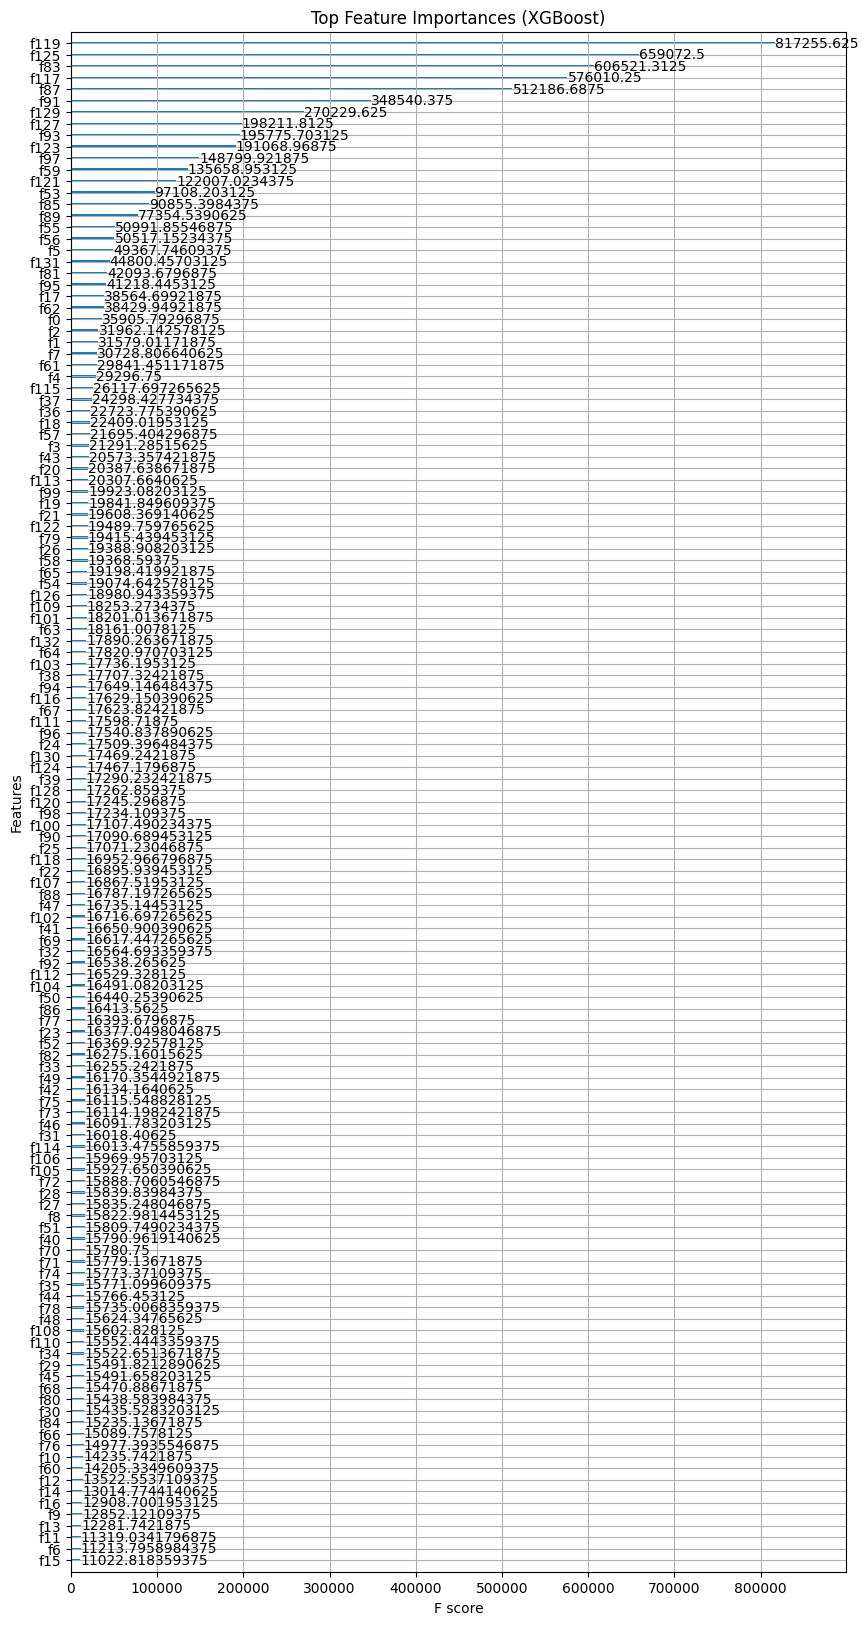

In [16]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, importance_type='gain',ax=ax)
plt.title("Top Feature Importances (XGBoost)")
plt.show()

# Make Submission CSV
We save our test predictions to submission.csv and plot our predictions. 

In [17]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission_v{VER}.csv",index=False)
sub.head()

,id,Price
0,300000,80.433304
1,300001,81.997124
2,300002,86.219679
3,300003,78.276776
4,300004,79.786473


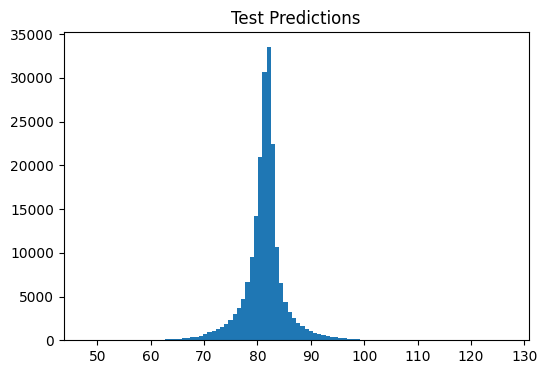

In [18]:
plt.figure(figsize=(6,4))
plt.hist(sub.Price,bins=100)
plt.title("Test Predictions")
plt.show()